## Libraries

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 19.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from math import sin, cos
import cv2
from scipy.io import loadmat 
import os
import joblib

import mediapipe as mp

import random as rd
rd.seed(0)

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Function to show axis on sample image

In [2]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# Try one image as example

## Read Image samples

### Turn to GC to authorise and mount your Google drive

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

### unzipping file of image

In [13]:
# !unzip -uq "/content/drive/My Drive/ML1_project/AFLW2000-3D.zip" -d "/content/drive/My Drive/ML1_project/ML_images"

### try to display images

In [5]:
# from google.colab.patches import cv2_imshow

img = cv2.imread('./AFLW2000/image00099.jpg')
#  #  keep the windows open, the notebook will continue running.
cv2.imshow('HelloWorld', img)
cv2.waitKey(3000) 
cv2.destroyWindow('HelloWorld')

## Try to use mediapipe

In [6]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils


with mp_face_mesh.FaceMesh(static_image_mode= True) as mesh_faces:
    #load Image:
    Img = cv2.imread('./AFLW2000/image00099.jpg')
    # convert BGR image to RGB  before processing
    results = mesh_faces.process(cv2.cvtColor(Img, cv2.COLOR_BGR2RGB))    # process: btrg3li ,3al, el wesh bs lazem ykon da5lha RGB image 3shan kda bn7wl el swr abl mand5lha 

    # print and draw face mesh on image:
    if results.multi_face_landmarks != None:
        for face in results.multi_face_landmarks:  # Detecte if there are more than one face in image
            print(len(face.landmark))
            for landmark in face.landmark:           # results.multi_face_landmarks.landmark: will return normalize numbers for (X, Y, Z), so we calculate relative x, y to denormalize these numbers
                x = landmark.x
                y = landmark.y

                shape = Img.shape
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])

                cv2.circle(Img, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=1)
        cv2.imshow('HelloWorld', Img)
        cv2.waitKey(3000) 
        cv2.destroyWindow('HelloWorld')

468


In [7]:
mat_file = loadmat('./AFLW2000/image00099.mat')
pose_para = mat_file['Pose_Para'][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]

cv2.imshow('HelloWorld', draw_axis(img, pitch, yaw, roll, size = 100))
cv2.waitKey(3000) 
cv2.destroyWindow('HelloWorld')

# Collect all data of all images

In [8]:
## Generate column names

columns = []
for i in range(1, 469):
    columns.append('x_'+str(i))
    columns.append('y_'+str(i))

In [9]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

data_lst = []
pitch_lst = []
yaw_lst = []
roll_lst = []
img_names = []

with mp_face_mesh.FaceMesh(static_image_mode= True) as mesh_faces:
    for img_name in os.listdir('./AFLW2000'):
        pts_lst = []
        if img_name.split('.')[-1].lower() in ['jpg', 'png', 'jpeg']:
            #load Image:
            Img = cv2.imread('./AFLW2000/' + img_name)
            # convert BGR image to RGB  before processing
            results = mesh_faces.process(cv2.cvtColor(Img, cv2.COLOR_BGR2RGB))    # process: btrg3li ,3al, el wesh bs lazem ykon da5lha RGB image 3shan kda bn7wl el swr abl mand5lha 

            # print and draw face mesh on image:
            if results.multi_face_landmarks != None:
                for face in results.multi_face_landmarks:  # Detecte if there are more than one face in image
                    # Nose 
                    nose_x = int(face.landmark[1].x * Img.shape[1])
                    nose_y = int(face.landmark[1].y * Img.shape[0])
                    # chin
                    chin_x = int(face.landmark[152].x * Img.shape[1])
                    chin_y = int(face.landmark[152].y * Img.shape[0])
                    # Max Dist
                    dist_x = nose_x - chin_x
                    dist_y = nose_y - chin_y

                    dist = np.sqrt(dist_x**2 + dist_y**2)

                    # print(len(face.landmark))
                    for landmark in face.landmark:           # results.multi_face_landmarks.landmark: will return normalize numbers for (X, Y, Z), so we calculate relative x, y to denormalize these numbers
                        x = landmark.x
                        y = landmark.y

                        shape = Img.shape
                        relative_x = int(x * shape[1])
                        relative_y = int(y * shape[0])

                        pts_lst.append((relative_x- nose_x) / dist)
                        pts_lst.append((relative_y- nose_y) / dist)


                    data_lst.append(pts_lst)
                    img_names.append(img_name)
      
                mat_file = loadmat('./AFLW2000/' + img_name.split(".")[0] + '.mat')
                pose_para = mat_file['Pose_Para'][0][:3]
                pitch = pose_para[0]
                yaw = pose_para[1]
                roll = pose_para[2]

                pitch_lst.append(pitch)
                yaw_lst.append(yaw)
                roll_lst.append(roll)

      
        cv2.circle(Img, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=1)

    cv2.imshow('HelloWorld', Img)
    cv2.waitKey(3000) 
    cv2.destroyWindow('HelloWorld')

In [10]:
len(data_lst)

1853

In [11]:
len(pitch_lst)

1853

In [12]:
data_lst[0][0]

-0.02351477044508147

In [13]:
data = pd.DataFrame(data_lst, columns=columns)
data['pitch'] = pitch_lst
data['yaw'] = yaw_lst
data['roll'] = roll_lst
data['names'] = img_names

In [14]:
data.head()

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_466,y_466,x_467,y_467,x_468,y_468,pitch,yaw,roll,names
0,-0.023515,0.258662,0.0,0.0,0.000000,0.047030,-0.058787,-0.399751,0.000000,-0.094059,...,0.270420,-0.728958,0.928833,-0.881804,0.987620,-0.928833,-0.399231,0.018227,0.085676,image00002.jpg
1,0.138885,0.277770,0.0,0.0,0.176763,0.101007,0.113633,-0.265144,0.000000,-0.088381,...,0.479784,-0.441907,0.959568,-0.517662,1.010072,-0.555540,0.470065,1.189533,0.300959,image00004.jpg
2,-0.022704,0.227038,0.0,0.0,-0.022704,0.045408,-0.113519,-0.317854,0.000000,-0.090815,...,0.068111,-0.544892,0.544892,-0.658411,0.567596,-0.681115,-0.184650,0.881137,-0.236852,image00006.jpg
3,0.180710,0.216852,0.0,0.0,0.108426,0.024095,-0.144568,-0.349372,-0.048189,-0.096379,...,0.108426,-0.734886,0.686697,-1.072211,0.722839,-1.132448,-0.175379,0.299208,-0.373374,image00008.jpg
4,0.078158,0.283321,0.0,0.0,0.029309,0.087927,-0.107467,-0.273552,-0.019539,-0.087927,...,0.058618,-0.498255,0.488485,-0.674110,0.527564,-0.693649,-0.026812,0.011965,-0.220662,image00013.jpg


In [15]:
data[data['names'] == 'image00002.jpg']

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_466,y_466,x_467,y_467,x_468,y_468,pitch,yaw,roll,names
0,-0.023515,0.258662,0.0,0.0,0.0,0.04703,-0.058787,-0.399751,0.0,-0.094059,...,0.27042,-0.728958,0.928833,-0.881804,0.98762,-0.928833,-0.399231,0.018227,0.085676,image00002.jpg


In [16]:
data.shape

(1853, 940)

# Start Machine Learning Model

In [17]:
X = data.drop(columns=['pitch', 'yaw', 'roll', 'names'])
Y_pitch = data['pitch']
Y_yaw = data['yaw']
Y_roll = data['roll']

In [18]:
X.head()

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467,x_468,y_468
0,-0.023515,0.258662,0.0,0.0,0.000000,0.047030,-0.058787,-0.399751,0.000000,-0.094059,...,0.364479,-0.811260,0.305692,-0.775987,0.270420,-0.728958,0.928833,-0.881804,0.987620,-0.928833
1,0.138885,0.277770,0.0,0.0,0.176763,0.101007,0.113633,-0.265144,0.000000,-0.088381,...,0.606043,-0.479784,0.542914,-0.454532,0.479784,-0.441907,0.959568,-0.517662,1.010072,-0.555540
2,-0.022704,0.227038,0.0,0.0,-0.022704,0.045408,-0.113519,-0.317854,0.000000,-0.090815,...,0.136223,-0.590300,0.090815,-0.567596,0.068111,-0.544892,0.544892,-0.658411,0.567596,-0.681115
3,0.180710,0.216852,0.0,0.0,0.108426,0.024095,-0.144568,-0.349372,-0.048189,-0.096379,...,0.204804,-0.831265,0.144568,-0.783076,0.108426,-0.734886,0.686697,-1.072211,0.722839,-1.132448
4,0.078158,0.283321,0.0,0.0,0.029309,0.087927,-0.107467,-0.273552,-0.019539,-0.087927,...,0.127006,-0.547104,0.078158,-0.517794,0.058618,-0.498255,0.488485,-0.674110,0.527564,-0.693649


In [19]:
X.shape

(1853, 936)

In [20]:
X.duplicated().sum()

0

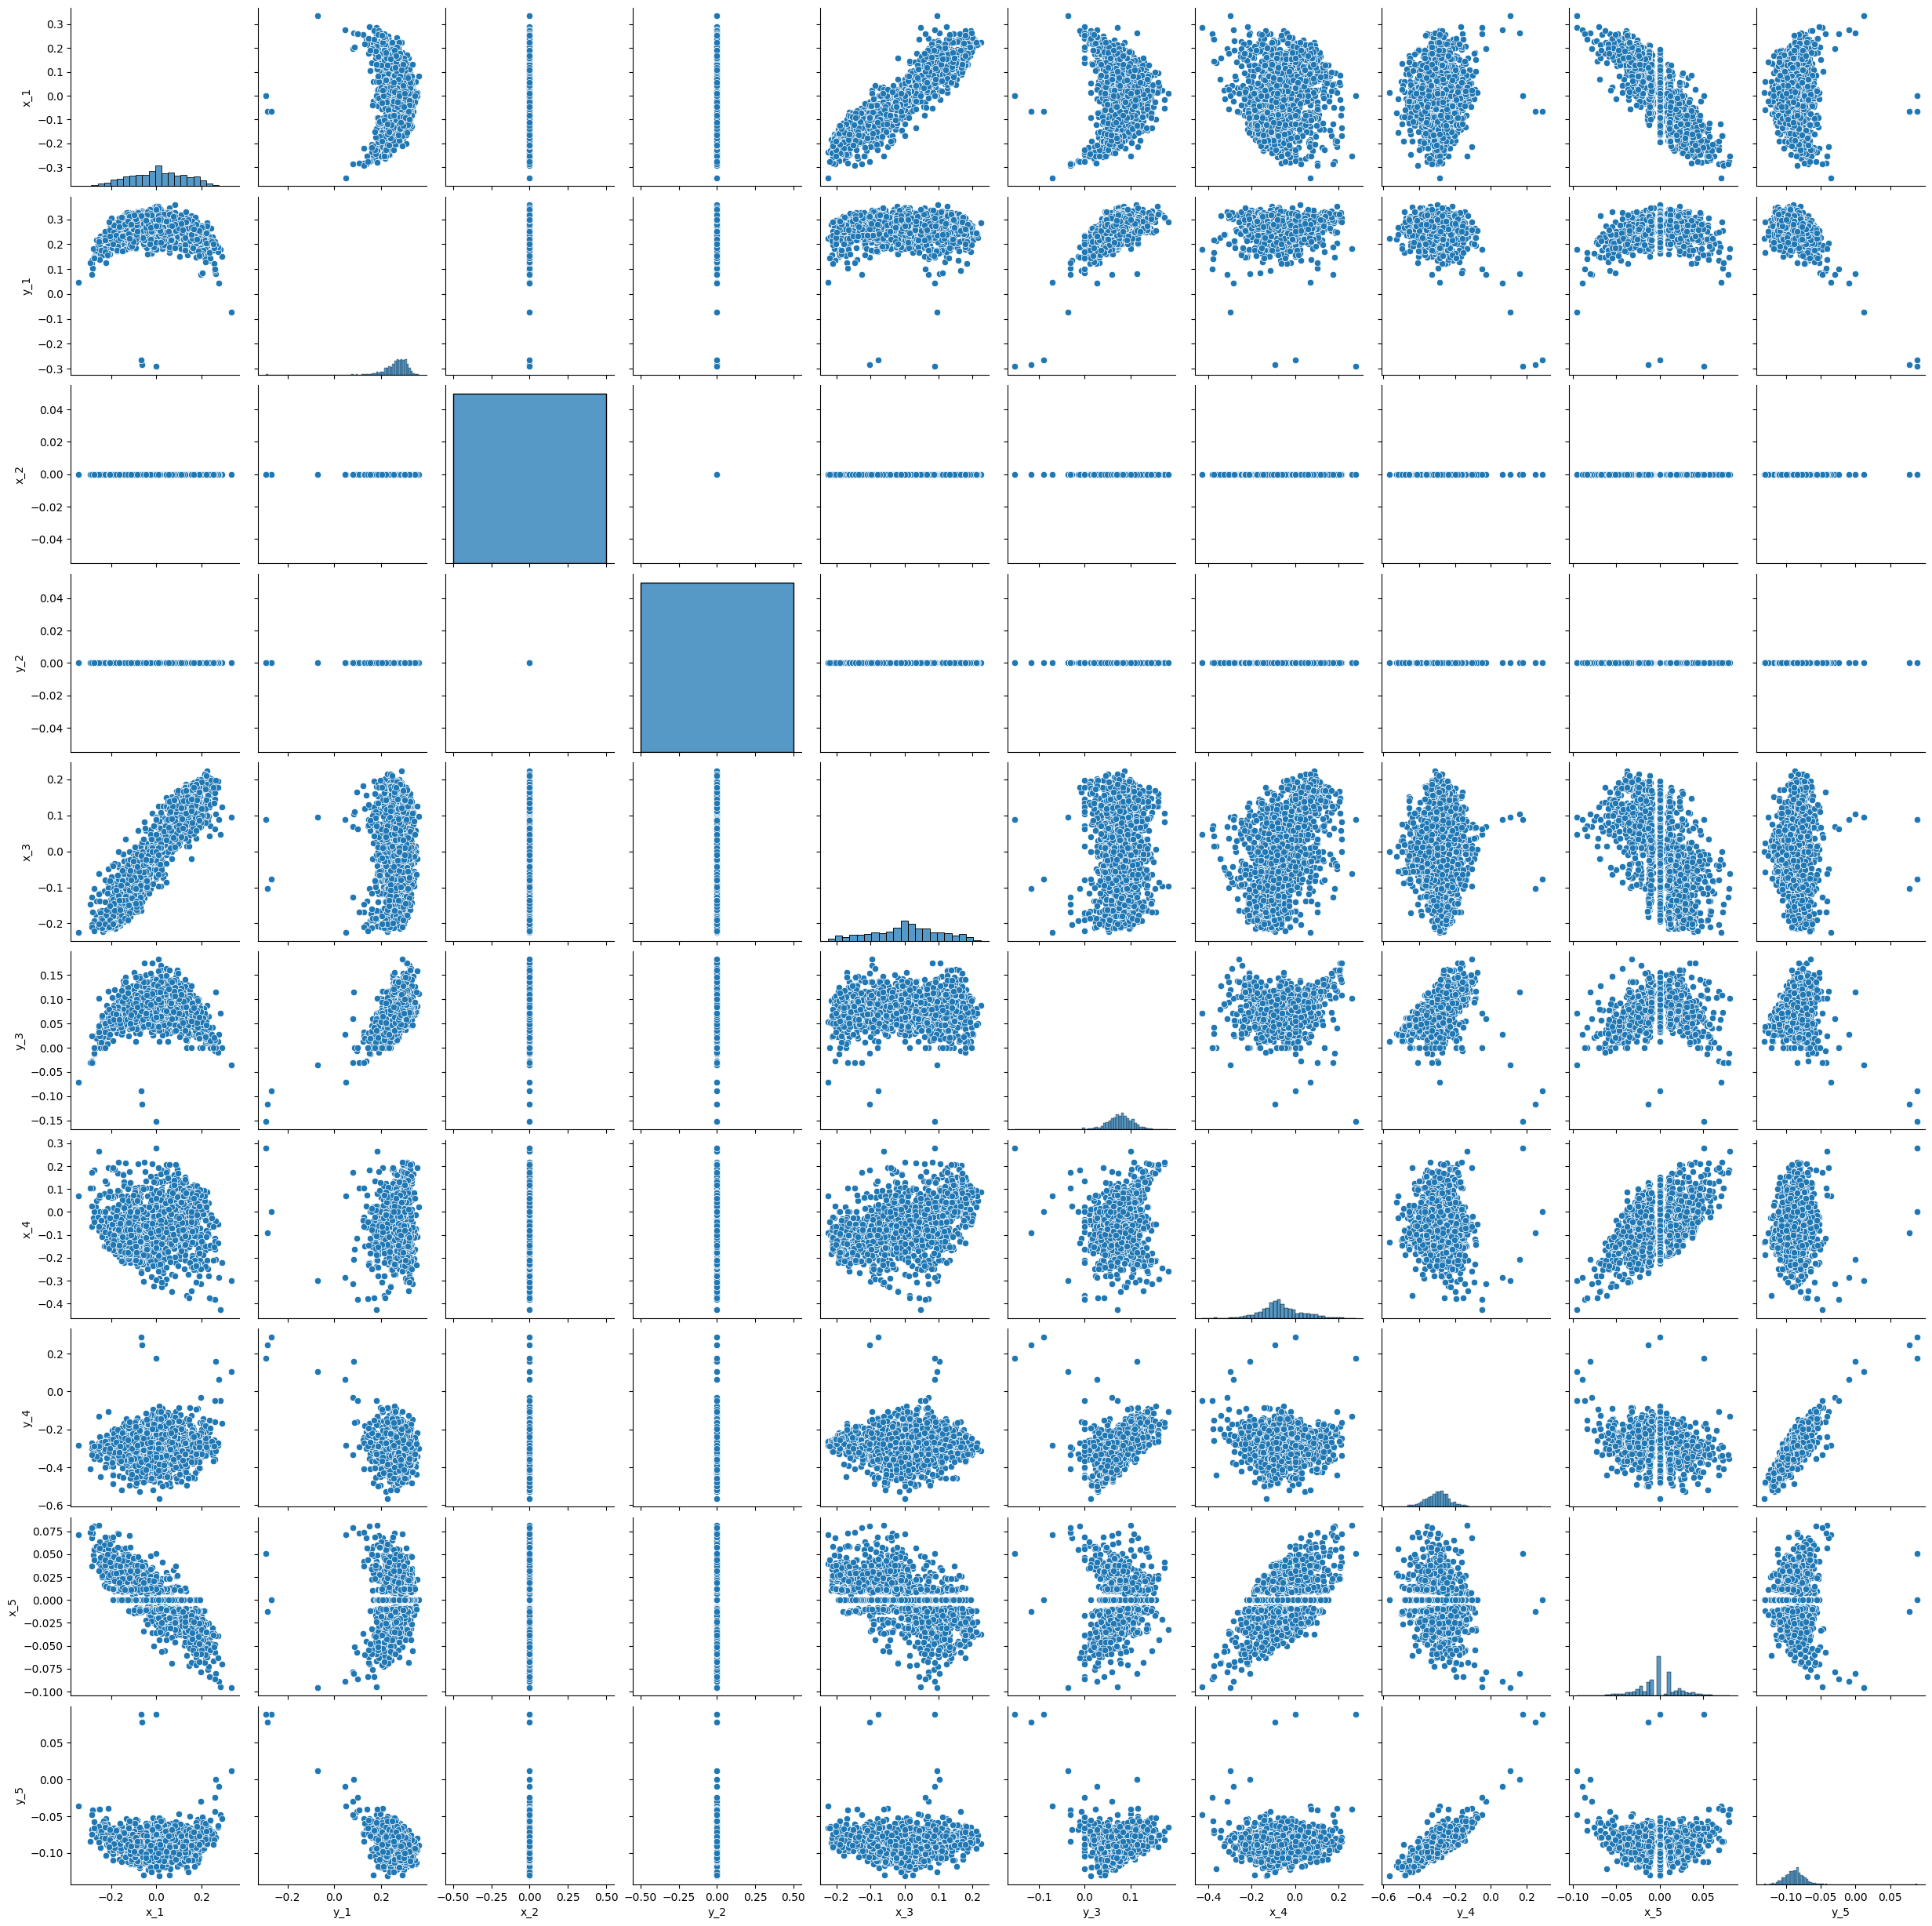

In [21]:
# sns.scatterplot(data['x_100'], data['y_100'])

sns.pairplot(X.iloc[:, :10])

<AxesSubplot: xlabel='x_10'>

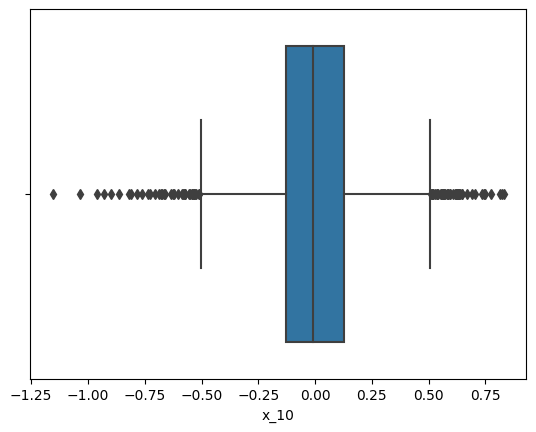

In [21]:
sns.boxplot(x = data['x_10'])

### split pitch data

In [22]:
x_pitch_train, x_pitch_validation, y_pitch_train, y_pitch_validation = train_test_split(X, Y_pitch, test_size=0.3, random_state=42)

### split yaw data

In [23]:
x_yaw_train, x_yaw_validation, y_yaw_train, y_yaw_validation = train_test_split(X, Y_yaw, test_size=0.3, random_state=42)

### split roll data

In [24]:
x_roll_train, x_roll_validation, y_roll_train, y_roll_validation = train_test_split(X, Y_roll, test_size=0.3, random_state=42)

## Training different models on our data
- LinearRegression
- SVR
- DecisionTreeRegressor
- AdaBoostRegressor
- GradientBoostingRegressor
- RandomForestRegressor

## Pitch Models

In [36]:
SGD_pitch_model = SGDRegressor().fit(x_pitch_train, y_pitch_train)
print("SGD Regression:", SGD_pitch_model.score(x_pitch_validation, y_pitch_validation))

SGD Regression: 0.5118843776633047


In [37]:
LR_pitch_model = LinearRegression().fit(x_pitch_train, y_pitch_train)
SVR_pitch_model = SVR().fit(x_pitch_train, y_pitch_train)
DT_pitch_model = DecisionTreeRegressor().fit(x_pitch_train, y_pitch_train)
Ada_pitch_model = AdaBoostRegressor().fit(x_pitch_train, y_pitch_train)
GB_pitch_model = GradientBoostingRegressor().fit(x_pitch_train, y_pitch_train)
RF_pitch_model = RandomForestRegressor().fit(x_pitch_train, y_pitch_train)

In [38]:
# print accuracy of each model on validation data
print("Scores of the models")
print("Linear regression:", LR_pitch_model.score(x_pitch_validation, y_pitch_validation))
print("SVR:", SVR_pitch_model.score(x_pitch_validation, y_pitch_validation))
print("Decession Tree:", DT_pitch_model.score(x_pitch_validation, y_pitch_validation))
print("Ada Boost:", Ada_pitch_model.score(x_pitch_validation, y_pitch_validation))
print("Gradient boosting:", GB_pitch_model.score(x_pitch_validation, y_pitch_validation))
print("Random Forest:", RF_pitch_model.score(x_pitch_validation, y_pitch_validation))

Scores of the models
Linear regression: -6.155268152276183
SVR: 0.6544620282705382
Decession Tree: -4.4057227852658745
Ada Boost: -0.11575769710072348
Gradient boosting: -2.992598746862466
Random Forest: -0.3875842602427999


In [39]:
# print Mean Absolute Error of each model on validation data

print("Mean Square Error of the models:")

LR_pitch_pred = LR_pitch_model.predict(x_pitch_validation)
print("Linear regression:", mean_absolute_error(LR_pitch_pred, y_pitch_validation))

SVR_pitch_pred = SVR_pitch_model.predict(x_pitch_validation)
print("SVR:", mean_absolute_error(SVR_pitch_pred, y_pitch_validation))

DT_pitch_pred = DT_pitch_model.predict(x_pitch_validation)
print("Decession Tree:", mean_absolute_error(DT_pitch_pred, y_pitch_validation))

Ada_pitch_pred = Ada_pitch_model.predict(x_pitch_validation)
print("Ada Boost:", mean_absolute_error(Ada_pitch_pred, y_pitch_validation))

GB_pitch_pred = GB_pitch_model.predict(x_pitch_validation)
print("Gradient boosting:", mean_absolute_error(GB_pitch_pred, y_pitch_validation))

RF_pitch_pred = RF_pitch_model.predict(x_pitch_validation)
print("Random Forest:", mean_absolute_error(RF_pitch_pred, y_pitch_validation))

Mean Square Error of the models:
Linear regression: 0.6389937870055344
SVR: 0.08938216382415724
Decession Tree: 0.15816199935687097
Ada Boost: 0.18047801736232705
Gradient boosting: 0.14669776189262873
Random Forest: 0.12591810921576024


## Yaw Models

In [44]:
SGD_yaw_model = SGDRegressor().fit(x_yaw_train, y_yaw_train)
print("SGD regression:", SGD_yaw_model.score(x_yaw_validation, y_yaw_validation))

SGD regression: 0.8917634566072266


In [45]:
LR_yaw_model = LinearRegression().fit(x_yaw_train, y_yaw_train)
SVR_yaw_model = SVR().fit(x_yaw_train, y_yaw_train)
DT_yaw_model = DecisionTreeRegressor().fit(x_yaw_train, y_yaw_train)
Ada_yaw_model = AdaBoostRegressor().fit(x_yaw_train, y_yaw_train)
GB_yaw_model = GradientBoostingRegressor().fit(x_yaw_train, y_yaw_train)
RF_yaw_model = RandomForestRegressor().fit(x_yaw_train, y_yaw_train)

In [46]:
# print accuracy of each model on validation data
print("Scores of the models")
print("Linear regression:", LR_yaw_model.score(x_yaw_validation, y_yaw_validation))
print("SVR:", SVR_yaw_model.score(x_yaw_validation, y_yaw_validation))
print("Decession Tree:", DT_yaw_model.score(x_yaw_validation, y_yaw_validation))
print("Ada Boost:", Ada_yaw_model.score(x_yaw_validation, y_yaw_validation))
print("Gradient boosting:", GB_yaw_model.score(x_yaw_validation, y_yaw_validation))
print("Random Forest:", RF_yaw_model.score(x_yaw_validation, y_yaw_validation))

Scores of the models
Linear regression: 0.5418391747289
SVR: 0.9182809569310368
Decession Tree: 0.8134583679173616
Ada Boost: 0.8362634819356949
Gradient boosting: 0.8344540578646309
Random Forest: 0.8173412440406397


In [47]:
# print Mean Absolute Error of each model on validation data
from sklearn.metrics import f1_score

print("Mean Square Error of the models:")

LR_yaw_pred = LR_yaw_model.predict(x_yaw_validation)
print("Linear regression:", mean_absolute_error(LR_yaw_pred, y_yaw_validation))

SVR_yaw_pred = SVR_yaw_model.predict(x_yaw_validation)
print("SVR:", mean_absolute_error(SVR_yaw_pred, y_yaw_validation))

DT_yaw_pred = DT_yaw_model.predict(x_yaw_validation)
print("Decision tree:", mean_absolute_error(DT_yaw_pred, y_yaw_validation))

Ada_yaw_pred = Ada_yaw_model.predict(x_yaw_validation)
print("Ada Boost:", mean_absolute_error(Ada_yaw_pred, y_yaw_validation))

GB_yaw_pred = GB_yaw_model.predict(x_yaw_validation)
print("Gradient boosting:", mean_absolute_error(GB_yaw_pred, y_yaw_validation))

RF_yaw_pred = RF_yaw_model.predict(x_yaw_validation)
print("Random Forest:", mean_absolute_error(RF_yaw_pred, y_yaw_validation))

Mean Square Error of the models:
Linear regression: 0.2658330049807607
SVR: 0.07072740492457057
Decision tree: 0.11444114200978438
Ada Boost: 0.14325251149713084
Gradient boosting: 0.09089592371606456
Random Forest: 0.08734215985210944


## Roll Models

In [62]:
SGD_roll_model = SGDRegressor().fit(x_roll_train, y_roll_train)
print("SGD regression:", SGD_roll_model.score(x_roll_validation, y_roll_validation))

SGD regression: 0.555364159997467


In [63]:
LR_roll_model = LinearRegression().fit(x_roll_train, y_roll_train)
SVR_roll_model = SVR().fit(x_roll_train, y_roll_train)
DT_roll_model = DecisionTreeRegressor().fit(x_roll_train, y_roll_train)
Ada_roll_model = AdaBoostRegressor().fit(x_roll_train, y_roll_train)
GB_roll_model = GradientBoostingRegressor().fit(x_roll_train, y_roll_train)
RF_roll_model = RandomForestRegressor().fit(x_roll_train, y_roll_train)

In [64]:
# print accuracy of each model on validation data
print("Scores of the models")
print("Linear regression:", LR_roll_model.score(x_roll_validation, y_roll_validation))
print("SVR:", SVR_roll_model.score(x_roll_validation, y_roll_validation))
print("Decession Tree:", DT_roll_model.score(x_roll_validation, y_roll_validation))
print("Ada Boost:", Ada_roll_model.score(x_roll_validation, y_roll_validation))
print("Gradient boosting:", GB_roll_model.score(x_roll_validation, y_roll_validation))
print("Random Forest:", RF_roll_model.score(x_roll_validation, y_roll_validation))

Scores of the models
Linear regression: -2.7234042772498026
SVR: 0.674290004555002
Decession Tree: -2.551529660336526
Ada Boost: -2.8745193137885656
Gradient boosting: -2.443687305196629
Random Forest: -1.8224442151323315


In [65]:
# print Mean Absolute Error of each model on validation data
from sklearn.metrics import f1_score

print("Mean Square Error of the models:")

LR_roll_pred = LR_roll_model.predict(x_roll_validation)
print("Linear regression:", mean_absolute_error(LR_roll_pred, y_roll_validation))

SVR_roll_pred = SVR_roll_model.predict(x_roll_validation)
print("SVR :", mean_absolute_error(SVR_roll_pred, y_roll_validation))

DT_roll_pred = DT_roll_model.predict(x_roll_validation)
print("Decession tree:", mean_absolute_error(DT_roll_pred, y_roll_validation))

Ada_roll_pred = Ada_roll_model.predict(x_roll_validation)
print("Ada Boost:", mean_absolute_error(Ada_roll_pred, y_roll_validation))

GB_roll_pred = GB_roll_model.predict(x_roll_validation)
print("Gradient boosting:", mean_absolute_error(GB_roll_pred, y_roll_validation))

RF_roll_pred = RF_roll_model.predict(x_roll_validation)
print("Random Forest:", mean_absolute_error(RF_roll_pred, y_roll_validation))

Mean Square Error of the models:
Linear regression: 0.5645094807959163
SVR : 0.07209909207597019
Decession tree: 0.12456356793825502
Ada Boost: 0.25705113731896706
Gradient boosting: 0.11360793616091477
Random Forest: 0.12083668699037355


# Try using Grid Search

### Pitch Data

In [66]:
svr_parameters = {'kernel': ['poly'],
                  'C': [0.1, 1 , 10 , 8 , 100]
                }
# use gridsearch to find the best hyperparameters 
svr = SVR()
svr_pitch_gs = GridSearchCV(svr, svr_parameters).fit(x_pitch_train, y_pitch_train)

# git the best model
svr_pitch_winner = svr_pitch_gs.best_estimator_

print(svr_pitch_winner.score(x_pitch_validation, y_pitch_validation))

print(svr_pitch_winner)

0.6766251251937652
SVR(C=10, kernel='poly')


In [67]:
svr_pitch_pred = svr_pitch_winner.predict(x_pitch_validation)

print(f'score: {svr_pitch_winner.score(x_pitch_validation, y_pitch_validation)}')
print(f"MAE: {mean_absolute_error(svr_pitch_pred, y_pitch_validation)}")

score: 0.6766251251937652
MAE: 0.08827706004707347


In [65]:
# use joblib to save the model
joblib.dump(svr_pitch_winner, './svr_pitch_Gridsearch_77_withouy_test.pkl')

['./svr_pitch_Gridsearch_77_withouy_test.pkl']

## Yaw Data

In [68]:
svr_parameters = {'kernel': ['poly'],
                  'C': [0.01, 0.1, 1 , 10, 50]
                }
# use gridsearch to find the best hyperparameters 
svr = SVR()
svr_yaw_gs = GridSearchCV(svr, svr_parameters).fit(x_yaw_train, y_yaw_train)

# git the best model
svr_yaw_winner = svr_yaw_gs.best_estimator_

print(svr_yaw_winner.score(x_yaw_validation, y_yaw_validation))

print(svr_yaw_winner)

0.9234707106765137
SVR(C=10, kernel='poly')


In [69]:
svr_yaw_pred = svr_yaw_winner.predict(x_yaw_validation)

print(f'score: {svr_yaw_winner.score(x_yaw_validation, y_yaw_validation)}')
print(f"MAE: {mean_absolute_error(svr_yaw_pred, y_yaw_validation)}")

score: 0.9234707106765137
MAE: 0.07273401097628512


In [83]:
joblib.dump(svr_yaw_winner, './svr_yaw_Gridsearch_957_without_test.pkl')

['./svr_yaw_Gridsearch_957_without_test.pkl']

## Roll Data

In [70]:
svr_parameters = {'kernel': ['rbf'],
                  'C': [0.1, 1 , 5, 6, 7,  9, 10],
                }
# use gridsearch to find the best hyperparameters 
svr = SVR()
svr_roll_gs = GridSearchCV(svr, svr_parameters).fit(x_roll_train, y_roll_train)

# git the best model
svr_roll_winner = svr_roll_gs.best_estimator_

print(svr_roll_winner.score(x_roll_validation, y_roll_validation))

print(svr_roll_winner)

0.674290004555002
SVR(C=1)


In [71]:
svr_roll_pred = svr_roll_winner.predict(x_roll_validation)

print(f'score: {svr_roll_winner.score(x_roll_validation, y_roll_validation)}')
print(f"MAE: {mean_absolute_error(svr_roll_pred, y_roll_validation)}")

score: 0.674290004555002
MAE: 0.07209909207597019


In [121]:
joblib.dump(svr_roll_winner, './svr_roll_Gridsearch_861_without_test.pkl')

['./svr_roll_Gridsearch_861_without_test.pkl']

## Try prediction from model

In [123]:
svr_pitch_winner.predict(x_pitch_validation)

array([-4.21388494e-01, -4.52049004e-01,  3.45274855e-01, -1.29808257e-01,
        4.66576809e-01, -3.43435076e-01, -2.27367156e-01, -1.21527922e-01,
       -1.02445445e-01, -7.26864320e-02, -5.41013816e-03, -3.43421357e-01,
       -1.09706467e-01, -1.09648686e-01, -2.07762713e-01, -2.99722692e-01,
       -3.24578963e-01, -2.56145238e-01, -4.63304825e-01,  4.07597084e-01,
        7.44299868e-01, -2.59853849e-01,  5.73858082e-01, -6.02340375e-02,
       -2.00058838e-01, -1.62406946e-01,  7.35099064e-02, -1.13805987e+00,
        1.85090333e-01,  3.65887567e-02, -2.34750246e-01, -1.51073219e-01,
       -5.39273167e-01, -3.10560106e-01, -2.25085701e-01, -1.79328886e-01,
       -9.69667055e-02, -3.02189662e-01, -2.65529621e-01, -1.18822006e-01,
        3.88145984e-02, -1.72734993e-01, -1.75242538e-01,  8.04286783e-02,
       -1.79817731e-01, -3.55187375e-01,  4.53399524e-02, -2.40687308e-01,
        1.51241418e-01,  5.95686704e-03, -1.26686387e-01, -5.42582037e-01,
       -2.87472633e-01, -

In [124]:
svr_yaw_winner.predict(x_yaw_validation)

array([-2.65134916e-02,  2.33591862e-01, -6.36897055e-01, -3.34515773e-01,
        2.56648016e-01,  2.72008306e-01, -6.68189712e-01, -1.00835492e+00,
       -5.89289894e-01,  2.43264434e-01, -1.44930864e-01,  6.02147568e-01,
       -5.85706831e-01,  5.12657171e-02,  5.84812774e-01, -9.34548755e-01,
       -9.98610410e-01,  1.62380127e-01,  5.65060222e-01, -1.05395033e+00,
        1.11114834e+00, -1.48556727e-01, -8.51785225e-01,  1.26511677e+00,
       -1.63091223e-01, -5.73126581e-01, -1.52980422e-01, -8.89819522e-01,
       -4.20067843e-01, -4.55018325e-02, -4.84687855e-02, -7.76579533e-02,
        7.26413795e-01,  1.20166184e-01, -1.03210049e+00, -1.80016495e-01,
       -4.75155449e-02,  3.88829272e-01,  1.70598589e-01,  7.07063045e-02,
       -4.35183324e-01,  6.40022591e-01,  7.43744470e-02,  2.22411023e-01,
        1.69634911e-01,  4.08162934e-01,  1.82419457e-01,  4.85771783e-01,
        1.21428457e+00, -1.48785403e-01, -1.24611694e-02,  1.01826163e+00,
        4.68660098e-01,  

In [125]:
svr_roll_winner.predict(x_roll_validation)

array([-6.05486878e-03, -2.85951998e-01, -1.11976983e+00,  3.42462444e-02,
       -1.52274760e-01, -5.71081500e-01,  2.87997194e-01,  2.24060470e-01,
        4.87618260e-02,  9.93639003e-02, -2.22981488e-02, -5.08874427e-01,
       -2.50769176e-01, -1.56571774e-01, -3.44258272e-01,  3.49433859e-01,
        4.22815376e-01,  1.40528280e-01, -5.02361911e-01, -4.19507992e-01,
        7.24022818e-01, -8.46988261e-02, -6.39628326e-01, -9.66153527e-02,
       -1.94217552e-03,  1.59782214e-01, -1.85822725e-01,  1.20163829e+00,
        2.94368238e-01, -1.18787065e-01, -1.36947877e-01,  6.33388418e-02,
       -5.55544904e-01, -9.83700588e-02,  2.20951643e-01,  1.19153529e-02,
       -1.05158692e-01, -4.21582784e-01,  1.04257459e-01, -1.00636407e-01,
       -2.96271937e-01, -3.12257024e-01, -3.17326634e-02, -4.02236685e-02,
       -6.97954804e-01, -1.73084765e-01,  4.07918814e-02,  2.58327084e-01,
        1.22689397e-01, -1.19187011e-01, -6.18457619e-01, -7.32853815e-01,
       -4.97421635e-01, -

In [25]:
y_pitch_validation

233    -0.429862
450    -0.532347
1240    0.186517
1693   -0.161427
411     0.514663
          ...   
277    -0.067771
1711   -0.267656
358    -0.109971
1033   -0.343861
236     0.118316
Name: pitch, Length: 556, dtype: float64

In [26]:
x_pitch_validation.iloc[0]

x_1      0.000000
y_1      0.237944
x_2      0.000000
y_2      0.000000
x_3      0.000000
           ...   
y_466   -0.832802
x_467    1.023157
y_467   -1.070746
x_468    1.082643
y_468   -1.118335
Name: 233, Length: 936, dtype: float64

In [27]:
data.iloc[1240]

x_1            0.157059
y_1            0.314118
x_2                 0.0
y_2                 0.0
x_3           -0.019632
              ...      
y_468         -0.883458
pitch          0.186517
yaw           -0.438183
roll          -0.875299
names    image02763.jpg
Name: 1240, Length: 940, dtype: object

In [75]:
img = cv2.imread('./AFLW2000/image02763.jpg')
mat_file = loadmat('./AFLW2000/image02763.mat')
pose_para = mat_file['Pose_Para'][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]

cv2.imshow('HelloWorld', draw_axis(img, pitch, yaw, roll, tdx = nose_x, tdy = nose_y, size = 100))
cv2.waitKey(3000) 
cv2.destroyWindow('HelloWorld')

In [76]:
img = cv2.imread('./AFLW2000/image02763.jpg')
# mat_file = loadmat('/content/drive/MyDrive/ML1_project/ML_images/AFLW2000/image00020.mat')

s1 = svr_pitch_winner.predict(np.array(x_pitch_validation.iloc[2]).reshape(1, -1))
s2 = svr_yaw_winner.predict(np.array(x_yaw_validation.iloc[2]).reshape(1, -1))
s3 = svr_roll_winner.predict(np.array(x_roll_validation.iloc[2]).reshape(1, -1))

cv2.imshow('HelloWorld', draw_axis(img, s1, s2, s3, tdx = nose_x, tdy = nose_y, size = 100))
cv2.waitKey(3000) 
cv2.destroyWindow('HelloWorld')

## Load models

In [28]:
best_svr_pitch_model = joblib.load('./svr_pitch_winner_71.2.pkl')

best_svr_yaw_model = joblib.load('./svr_yaw_winner_94.9.pkl')

best_svr_roll_model = joblib.load('./svr_roll_winner_85.6.pkl')

In [29]:
print(Y_pitch.iloc[1240])
print(Y_yaw.iloc[1240])
print(Y_roll.iloc[1240])

0.18651725351810455
-0.4381827712059021
-0.8752993941307068


In [30]:
s1 = best_svr_pitch_model.predict(np.array(x_pitch_validation.iloc[2]).reshape(1, -1))
s2 = best_svr_yaw_model.predict(np.array(x_yaw_validation.iloc[2]).reshape(1, -1))
s3 = best_svr_roll_model.predict(np.array(x_roll_validation.iloc[2]).reshape(1, -1))

print(s1)
print(s2)
print(s3)

[0.15108503]
[-0.35250154]
[-0.9753013]


In [31]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils


data_lst = []

with mp_face_mesh.FaceMesh(static_image_mode= True) as mesh_faces:
    #load Image:
    pts_lst = []
    Img = cv2.imread('./andrew.jpg')
    # convert BGR image to RGB  before processing
    results = mesh_faces.process(cv2.cvtColor(Img, cv2.COLOR_BGR2RGB))    # process: btrg3li ,3al, el wesh bs lazem ykon da5lha RGB image 3shan kda bn7wl el swr abl mand5lha 

  # print and draw face mesh on image:
    if results.multi_face_landmarks != None:
        for face in results.multi_face_landmarks:  # Detecte if there are more than one face in image
#             print(len(face.landmark))
            # Nose 
            nose_x = int(face.landmark[1].x * Img.shape[1])
            nose_y = int(face.landmark[1].y * Img.shape[0])
            # chin
            chin_x = int(face.landmark[152].x * Img.shape[1])
            chin_y = int(face.landmark[152].y * Img.shape[0])
            # Max Dist
            dist_x = nose_x - chin_x
            dist_y = nose_y - chin_y

            dist = np.sqrt(dist_x**2 + dist_y**2)

        for landmark in face.landmark:           # results.multi_face_landmarks.landmark: will return normalize numbers for (X, Y, Z), so we calculate relative x, y to denormalize these numbers
            x = landmark.x
            y = landmark.y

            shape = Img.shape
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])

            pts_lst.append((relative_x- nose_x) / dist)
            pts_lst.append((relative_y- nose_y) / dist)

            cv2.circle(Img, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=1)

        data_lst.append(pts_lst)

    cv2.imshow('HelloWorld', Img)
    cv2.waitKey(3000) 
    cv2.destroyWindow('HelloWorld')

In [32]:
img = cv2.imread('./andrew.jpg')

s1 = best_svr_pitch_model.predict(data_lst)
s2 = best_svr_yaw_model.predict(data_lst)
s3 = best_svr_roll_model.predict(data_lst)

cv2.imshow('HelloWorld',draw_axis(img, s1, s2, s3, tdx=nose_x, tdy=nose_y, size = 100))
cv2.waitKey(3000) 
cv2.destroyWindow('HelloWorld')

## Video Implementation

In [34]:
# Video with skipping frames

cam = cv2.VideoCapture('./Dudu.mp4')

# cam = cv2.VideoCapture("http://192.168.1.2:4747/video")# connecting to ip cam

width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

#print(width,height)

cam.set(cv2.CAP_PROP_FPS, 30)
cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

size = (width, height)
result = cv2.VideoWriter('Dudo_con1.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, size)

i=0 #frame counter
frameTime = 1 # time of each frame in ms, you can add logic to change this value.

data_lst = []
with mp_face_mesh.FaceMesh(static_image_mode= False, refine_landmarks= False) as mesh_faces:
    while cam.isOpened():
        pts_lst = []
        ret = cam.grab() #grab frame
        i=i+1 #increment counter
        
        if i % 3 == 0: # display only one third of the frames, you can change this parameter according to your needs

            #load Image:
            ret, frame = cam.retrieve() #decode frame

            if not ret:
                print('end')
                break

            # convert BGR image to RGB  before processing
            results = mesh_faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))    # process: btrg3li ,3al, el wesh bs lazem ykon da5lha RGB image 3shan kda bn7wl el swr abl mand5lha 

            # print and draw face mesh on image:
            if results.multi_face_landmarks != None:
                for face in results.multi_face_landmarks:  # Detecte if there are more than one face in image
                    # Nose 
                    nose_x = int(face.landmark[1].x * frame.shape[1])
                    nose_y = int(face.landmark[1].y * frame.shape[0])
                    
                    # chin
                    chin_x = int(face.landmark[152].x * frame.shape[1])
                    chin_y = int(face.landmark[152].y * frame.shape[0])
                    
                    # Max Dist
                    dist_x = nose_x - chin_x
                    dist_y = nose_y - chin_y

                    dist = np.sqrt(dist_x**2 + dist_y**2)

                    for landmark in face.landmark:           # results.multi_face_landmarks.landmark: will return normalize numbers for (X, Y, Z), so we calculate relative x, y to denormalize these numbers
                        x = landmark.x
                        y = landmark.y

                        shape = frame.shape
                        relative_x = int(x * shape[1])
                        relative_y = int(y * shape[0])

                        pts_lst.append((relative_x- nose_x) / dist)
                        pts_lst.append((relative_y- nose_y) / dist)

                      # cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=1)  
                data_lst.append(pts_lst)                     
                # cv2_imshow(frame)

                if cv2.waitKey(frameTime) & 0xFF == ord('q'):
                    print('end')
                    break

                s1 = best_svr_pitch_model.predict(np.array(pts_lst).reshape(1,-1))
                s2 = best_svr_yaw_model.predict(np.array(pts_lst).reshape(1,-1))
                s3 = best_svr_roll_model.predict(np.array(pts_lst).reshape(1,-1))

                cv2.imshow('HelloWorld',draw_axis(frame, s1, s2, s3, tdx=nose_x, tdy=nose_y, size = 100))

                result.write(frame)

cam.release()
cv2.destroyAllWindows()
result.release()

end
